In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64
from sklearn import metrics
from scipy.stats import zscore
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    #if target_type in (np.int64, np.int32):
        # Classification
    dummies = pd.get_dummies(df[target])
    return df[result].to_numpy().astype(np.float32), dummies.to_numpy().astype(np.float32)
    #else:
        # Regression
       # return df[result].to_numpy().astype(np.float32), df[target].to_numpy().astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING,low_memory=False)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

def analyze_label(df):
    total = float(len(df))
    uniques = df['Label'].unique()
    unique_count = len(uniques)
    print("** Label:{}".format(expand_categories(df['Label'])))
                            
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc(pred, y):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

In [2]:
# Analyze CIC IDS 2018 Infilteration

path = 'E:/Downloads/UNI/4/Otros/TFG/Datasets/CIC IDS 2018/Datasets/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv'
 
print(path)

df = pd.read_csv(path, header=None,low_memory=False)

print("features iniciales-------------------------------")
print(len(df.columns))

df.columns = [
    'Dst Port',
    'Protocol',
    'Timestamp',
    'Flow Duration',
    'Tot Fwd Pkts',
    'Tot Bwd Pkts',
    'TotLen Fwd Pkts',
    'TotLen Bwd Pkts',
    'Fwd Pkt Len Max',
    'Fwd Pkt Len Min',
    'Fwd Pkt Len Mean',
    'Fwd Pkt Len Std',
    'Bwd Pkt Len Max',
    'Bwd Pkt Len Min',
    'Bwd Pkt Len Mean',
    'Bwd Pkt Len Std',
    'Flow Byts/s',
    'Flow Pkts/s',
    'Flow IAT Mean',
    'Flow IAT Std',
    'Flow IAT Max',
    'Flow IAT Min',
    'Fwd IAT Tot',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Fwd IAT Max',
    'Fwd IAT Min',
    'Bwd IAT Tot',
    'Bwd IAT Mean',
    'Bwd IAT Std',
    'Bwd IAT Max',
    'Bwd IAT Min',
    'Fwd PSH Flags',
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'Fwd Header Len',
    'Bwd Header Len',
    'Fwd Pkts/s',
    'Bwd Pkts/s',
    'Pkt Len Min',
    'Pkt Len Max',
    'Pkt Len Mean',
    'Pkt Len Std',
    'Pkt Len Var',
    'FIN Flag Cnt',
    'SYN Flag Cnt',
    'RST Flag Cnt',
    'PSH Flag Cnt',
    'ACK Flag Cnt',
    'URG Flag Cnt',
    'CWE Flag Count',
    'ECE Flag Cnt',
    'Down/Up Ratio',
    'Pkt Size Avg',
    'Fwd Seg Size Avg',
    'Bwd Seg Size Avg',
    'Fwd Byts/b Avg',
    'Fwd Pkts/b Avg',
    'Fwd Blk Rate Avg',
    'Bwd Byts/b Avg',
    'Bwd Pkts/b Avg',
    'Bwd Blk Rate Avg',
    'Subflow Fwd Pkts',
    'Subflow Fwd Byts',
    'Subflow Bwd Pkts',
    'Subflow Bwd Byts',
    'Init Fwd Win Byts',
    'Init Bwd Win Byts',
    'Fwd Act Data Pkts',
    'Fwd Seg Size Min',
    'Active Mean',
    'Active Std',
    'Active Max',
    'Active Min',
    'Idle Mean',
    'Idle Std',
    'Idle Max',
    'Idle Min',
    'Label'
]

print("features nombradas-------------------------------")
print(len(df.columns))

df.drop(columns=['Timestamp',
                 'Fwd Byts/b Avg',
                 'Fwd Pkts/b Avg',
                 'CWE Flag Count',
                 'Bwd PSH Flags',
                 'Fwd URG Flags',
                 'Bwd URG Flags',
                 'Bwd Blk Rate Avg',
                 'Bwd Pkts/b Avg',
                 'Bwd Byts/b Avg',
                 'Fwd Blk Rate Avg',], axis=1, inplace=True)

encode_text_dummy(df, 'RST Flag Cnt')
encode_text_dummy(df, 'PSH Flag Cnt')
encode_text_dummy(df, 'ACK Flag Cnt')
encode_text_dummy(df, 'URG Flag Cnt')
encode_text_dummy(df, 'ECE Flag Cnt')
df['Down/Up Ratio'] = df['Down/Up Ratio'].astype(float)
encode_numeric_range(df, 'Down/Up Ratio')
df['Pkt Size Avg'] = df['Pkt Size Avg'].astype(float)
encode_numeric_range(df, 'Pkt Size Avg')
df['Fwd Seg Size Avg'] = df['Fwd Seg Size Avg'].astype(float)
encode_numeric_range(df, 'Fwd Seg Size Avg')
df['Bwd Seg Size Avg'] = df['Bwd Seg Size Avg'].astype(float)
encode_numeric_range(df, 'Bwd Seg Size Avg')
df['Bwd IAT Min'] = df['Bwd IAT Min'].astype(float)
encode_numeric_range(df, 'Bwd IAT Min')
df['Fwd Pkts/s'] = df['Fwd Pkts/s'].astype(float)
encode_numeric_range(df, 'Fwd Pkts/s')
df['Bwd Pkts/s'] = df['Bwd Pkts/s'].astype(float)
encode_numeric_range(df, 'Bwd Pkts/s')
df['Pkt Len Min'] = df['Pkt Len Min'].astype(float)
encode_numeric_range(df, 'Pkt Len Min')
df['Pkt Len Max'] = df['Pkt Len Max'].astype(float)
encode_numeric_range(df, 'Pkt Len Max')
df['Pkt Len Mean'] = df['Pkt Len Mean'].astype(float)
encode_numeric_range(df, 'Pkt Len Mean')
df['Pkt Len Std'] = df['Pkt Len Std'].astype(float)
encode_numeric_range(df, 'Pkt Len Std')
df['Pkt Len Var'] = df['Pkt Len Var'].astype(float)
encode_numeric_range(df, 'Pkt Len Var')
encode_text_dummy(df, 'FIN Flag Cnt')
encode_text_dummy(df, 'SYN Flag Cnt')
df['Bwd IAT Mean'] = df['Bwd IAT Mean'].astype(float)
encode_numeric_range(df, 'Bwd IAT Mean')
df['Bwd IAT Std'] = df['Bwd IAT Std'].astype(float)
encode_numeric_range(df, 'Bwd IAT Std')
df['Bwd IAT Max'] = df['Bwd IAT Max'].astype(float)
encode_numeric_range(df, 'Bwd IAT Max')
encode_text_dummy(df, 'Fwd PSH Flags')
df['Fwd Header Len'] = df['Fwd Header Len'].astype(float)
encode_numeric_range(df, 'Fwd Header Len')
df['Bwd Header Len'] = df['Bwd Header Len'].astype(float)
encode_numeric_range(df, 'Bwd Header Len')
df['Fwd Act Data Pkts'] = df['Fwd Act Data Pkts'].astype(float)
encode_numeric_range(df, 'Fwd Act Data Pkts')
df['Fwd Seg Size Min'] = df['Fwd Seg Size Min'].astype(float)
encode_numeric_range(df, 'Fwd Seg Size Min')
df['Active Mean'] = df['Active Mean'].astype(float)
encode_numeric_range(df, 'Active Mean')
df['Active Std'] = df['Active Std'].astype(float)
encode_numeric_range(df, 'Active Std')
df['Active Max'] = df['Active Max'].astype(float)
encode_numeric_range(df, 'Active Max')
df['Active Min'] = df['Active Min'].astype(float)
encode_numeric_range(df, 'Active Min')
df['Idle Mean'] = df['Idle Mean'].astype(float)
encode_numeric_range(df, 'Idle Mean')
df['Idle Std'] = df['Idle Std'].astype(float)
encode_numeric_range(df, 'Idle Std')
df['Idle Max'] = df['Idle Max'].astype(float)
encode_numeric_range(df, 'Idle Max')
df['Idle Min'] = df['Idle Min'].astype(float)
encode_numeric_range(df, 'Idle Min')
df['Flow IAT Std'] = df['Flow IAT Std'].astype(float)
encode_numeric_range(df, 'Flow IAT Std')
df['Flow IAT Max'] = df['Flow IAT Max'].astype(float)
encode_numeric_range(df, 'Flow IAT Max')
df['Flow IAT Min'] = df['Flow IAT Min'].astype(float)
encode_numeric_range(df, 'Flow IAT Min')
df['Fwd IAT Tot'] = df['Fwd IAT Tot'].astype(float)
encode_numeric_range(df, 'Fwd IAT Tot')
df['Fwd IAT Mean'] = df['Fwd IAT Mean'].astype(float)
encode_numeric_range(df, 'Fwd IAT Mean')
df['Fwd IAT Std'] = df['Fwd IAT Std'].astype(float)
encode_numeric_range(df, 'Fwd IAT Std')
df['Fwd IAT Max'] = df['Fwd IAT Max'].astype(float)
encode_numeric_range(df, 'Fwd IAT Max')
df['Fwd IAT Min'] = df['Fwd IAT Min'].astype(float)
encode_numeric_range(df, 'Fwd IAT Min')
df['Bwd IAT Tot'] = df['Bwd IAT Tot'].astype(float)
encode_numeric_range(df, 'Bwd IAT Tot')
df['Dst Port'] = df['Dst Port'].astype(float)
encode_numeric_range(df, 'Dst Port')
encode_text_dummy(df, 'Protocol')
df['Flow Duration'] = df['Flow Duration'].astype(float)
encode_numeric_range(df, 'Flow Duration')
df['Tot Fwd Pkts'] = df['Tot Fwd Pkts'].astype(float)
encode_numeric_range(df, 'Tot Fwd Pkts')
df['Tot Bwd Pkts'] = df['Tot Bwd Pkts'].astype(float)
encode_numeric_range(df, 'Tot Bwd Pkts')
df['TotLen Fwd Pkts'] = df['TotLen Fwd Pkts'].astype(float)
encode_numeric_range(df, 'TotLen Fwd Pkts')
df['TotLen Bwd Pkts'] = df['TotLen Bwd Pkts'].astype(float)
encode_numeric_range(df, 'TotLen Bwd Pkts')
df['Fwd Pkt Len Max'] = df['Fwd Pkt Len Max'].astype(float)
encode_numeric_range(df, 'Fwd Pkt Len Max')
df['Fwd Pkt Len Min'] = df['Fwd Pkt Len Min'].astype(float)
encode_numeric_range(df, 'Fwd Pkt Len Min')
df['Fwd Pkt Len Mean'] = df['Fwd Pkt Len Mean'].astype(float)
encode_numeric_range(df, 'Fwd Pkt Len Mean')
df['Fwd Pkt Len Std'] = df['Fwd Pkt Len Std'].astype(float)
encode_numeric_range(df, 'Fwd Pkt Len Std')
df['Bwd Pkt Len Max'] = df['Bwd Pkt Len Max'].astype(float)
encode_numeric_range(df, 'Bwd Pkt Len Max')
df['Bwd Pkt Len Min'] = df['Bwd Pkt Len Min'].astype(float)
encode_numeric_range(df, 'Bwd Pkt Len Min')
df['Bwd Pkt Len Mean'] = df['Bwd Pkt Len Mean'].astype(float)
encode_numeric_range(df, 'Bwd Pkt Len Mean')
df['Bwd Pkt Len Std'] = df['Bwd Pkt Len Std'].astype(float)
encode_numeric_range(df, 'Bwd Pkt Len Std')
df['Flow Byts/s'] = df['Flow Byts/s'].astype(float)
encode_numeric_range(df, 'Flow Byts/s')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype(float)
encode_numeric_range(df, 'Flow Pkts/s')
df['Flow IAT Mean'] = df['Flow IAT Mean'].astype(float)
encode_numeric_range(df, 'Flow IAT Mean')
df['Init Bwd Win Byts'] = df['Init Bwd Win Byts'].astype(float)
encode_numeric_range(df, 'Init Bwd Win Byts')
df['Init Fwd Win Byts'] = df['Init Fwd Win Byts'].astype(float)
encode_numeric_range(df, 'Init Fwd Win Byts')
df['Subflow Bwd Byts'] = df['Subflow Bwd Byts'].astype(float)
encode_numeric_range(df, 'Subflow Bwd Byts')
df['Subflow Bwd Pkts'] = df['Subflow Bwd Pkts'].astype(float)
encode_numeric_range(df, 'Subflow Bwd Pkts')
df['Subflow Fwd Byts'] = df['Subflow Fwd Byts'].astype(float)
encode_numeric_range(df, 'Subflow Fwd Byts')
df['Subflow Fwd Pkts'] = df['Subflow Fwd Pkts'].astype(float)
encode_numeric_range(df, 'Subflow Fwd Pkts')


print("features finales-------------------------------")
print(len(df.columns))
print(list(df.columns))
display(df[0:5])

analyze_label(df)

E:/Downloads/UNI/4/Otros/TFG/Datasets/CIC IDS 2018/Datasets/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv
features iniciales-------------------------------
80
features nombradas-------------------------------
80
features finales-------------------------------
79
['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts'

,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,ECE Flag Cnt-1,FIN Flag Cnt-0,FIN Flag Cnt-1,SYN Flag Cnt-0,SYN Flag Cnt-1,Fwd PSH Flags-0,Fwd PSH Flags-1,Protocol-0,Protocol-6,Protocol-17
0,-0.986480,-0.998422,-0.999918,-0.999737,-0.99999,-0.999787,-0.922785,-1.0,-0.91991,-0.903773,...,1,1,0,1,0,1,0,0,1,0
1,-0.986480,-0.999997,-0.999984,-1.000000,-1.00000,-1.000000,-1.000000,-1.0,-1.00000,-1.000000,...,0,1,0,1,0,1,0,0,1,0
2,-0.986419,-0.997242,-0.999967,-0.999962,-1.00000,-1.000000,-1.000000,-1.0,-1.00000,-1.000000,...,0,1,0,1,0,1,0,0,1,0
3,-0.986480,-0.998293,-0.999918,-0.999737,-0.99999,-0.999787,-0.922785,-1.0,-0.91991,-0.903773,...,1,1,0,1,0,1,0,0,1,0
4,-0.986480,-0.999997,-0.999984,-1.000000,-1.00000,-1.000000,-1.000000,-1.0,-1.00000,-1.000000,...,0,1,0,1,0,1,0,0,1,0


** Label:[Benign:88.77%,Infilteration:11.23%]


Inicio----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid 
Train on 459803 samples, validate on 153268 samples
Epoch 1/1000
459803/459803 [==============================] - 27s 58us/sample - loss: 0.3536 - accuracy: 0.8874 - val_loss: 0.3501 - val_accuracy: 0.8883
Epoch 2/1000
459803/459803 [==============================] - 25s 54us/sample - loss: 0.3520 - accuracy: 0.8874 - val_loss: 0.3504 - val_accuracy: 0.8883
Epoch 3/1000
459803/459803 [==============================] - 26s 57us/sample - loss: 0.3520 - accuracy: 0.8874 - val_loss: 0.3501 - val_accuracy: 0.8883
Epoch 4/1000
459803/459803 [==============================] - 27s 59us/sample - loss: 0.3520 - accuracy: 0.8874 - val_loss: 0.3501 - val_accuracy: 0.8883
Epoch 5/1000
459803/459803 [==============================] - 24s 53us/sample - loss: 0.3520 - accuracy: 0.8874 - val_loss: 0.3501 - val_accuracy: 0.8883
Epoch 6/10

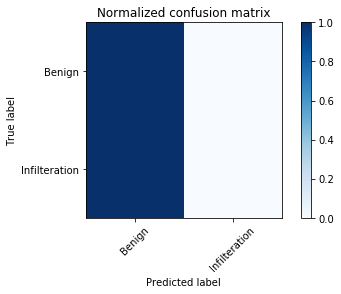

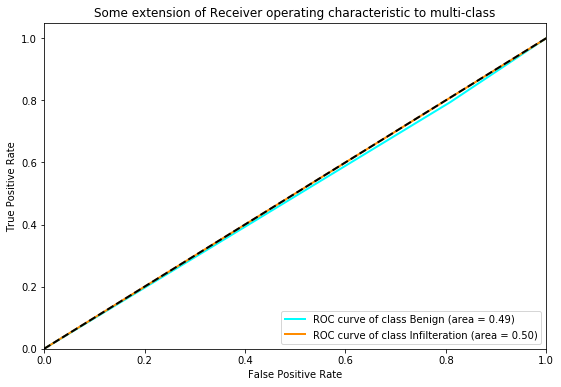

Fin----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid 


In [3]:
df.dropna(inplace=True,axis=1)

x, y = to_xy(df,'Label')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)


print("Inicio----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid ")

model6 = Sequential()

model6.add(Dense(68, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(32, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(1, kernel_initializer='normal'))
model6.add(Dense(y.shape[1],activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model6.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)

# Measure accuracy
pred = model6.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))
model6.summary()
model6.get_config()

#Accuracy
pred = model6.predict(x_test)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

#Confusion Matrix
dummies = pd.get_dummies(df['Label']) # Classification
species = dummies.columns

pred = model6.predict(x_test)
pred = np.argmax(pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, species, title='Normalized confusion matrix')

plt.show()

#ROC
pred = model6.predict(x_test)
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure(figsize=(9,6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

print("Fin----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid ")


Confusion matrix, without normalization


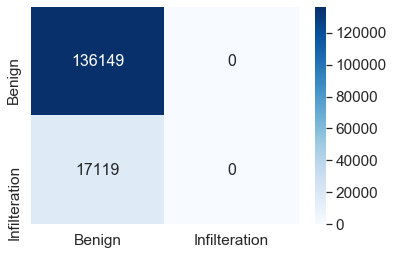

In [4]:
import seaborn as sn

print('Confusion matrix, without normalization')
    
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d", xticklabels=species, yticklabels=species, cmap=plt.cm.Blues) # font size


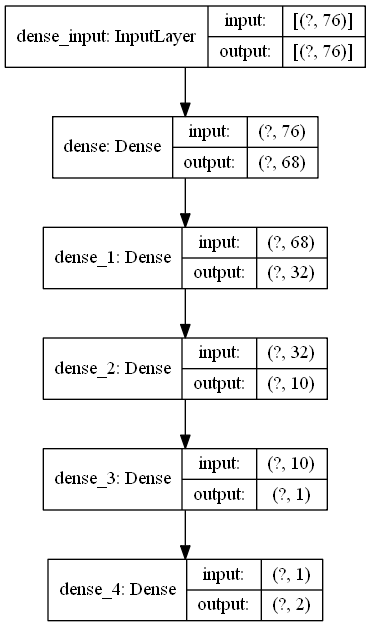

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
###BAD###

[1.87 0.87 0.87]
[1.13 0.13 0.13]


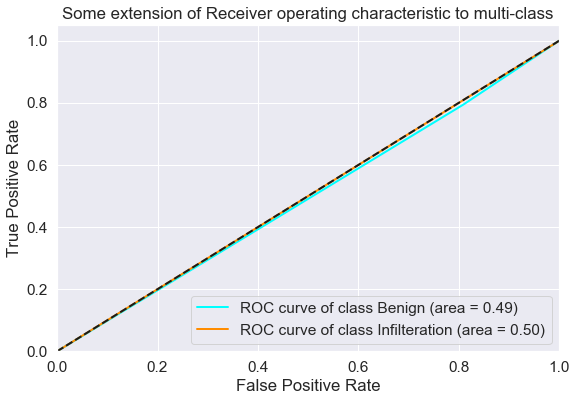

In [8]:
#ROC
pred = model6.predict(x_test)
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], th = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(th)
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure(figsize=(9,6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()